### **Semantic Segmentation w/ U-Net & U-Net++**  
#### **(1) KITTI Îç∞Ïù¥ÌÑ∞ ÏÖã**  
#### **(2) U-Net Î™®Îç∏ Íµ¨ÏÑ±**  
#### **(3) U-Net++ Î™®Îç∏ Íµ¨ÏÑ±**  
#### **(4) Ï†ïÏÑ±Ï†Å/Ï†ïÎüâÏ†Å ÌèâÍ∞Ä**

In [1]:
#ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º Î°úÎìúÌï©ÎãàÎã§. 
import os
import PIL
import math
import skimage
import albumentations
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.9.0
1.22.3
9.4.0
0.19.3
1.3.1


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---

### **(1) KITTI Îç∞Ïù¥ÌÑ∞ ÏÖã**

[Îç∞Ïù¥ÌÑ∞ ÏÖã]  
https://www.cvlibs.net/datasets/kitti/eval_semantics.php  
[Îç∞Ïù¥ÌÑ∞ info]  
https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py  
[Íµ¨ÌòÑ Ï∞∏Í≥† ÎßÅÌÅ¨]  
Keras SequenceÏóê Í∏∞Î∞òÌïú Dataloader  
https://hwiyong.tistory.com/241  
AlbumentationÏùÑ Ï†ÅÏö©Ìïú Keras sequence  
https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac 

**ÎèÑÎ°úÏùò Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),**


**[Îç∞Ïù¥ÌÑ∞ Î°úÎçî(data loader) ÎßåÎì§Í∏∞]**


- input : (224, 224)  
- output : (224, 244)

In [3]:
# data augmentation
def build_augmentation(is_train=True):
  if is_train:    # ÌõàÎ†®Ïö© Îç∞Ïù¥ÌÑ∞Ïùº Í≤ΩÏö∞
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%Ïùò ÌôïÎ•†Î°ú Ï¢åÏö∞ÎåÄÏπ≠
                    RandomSizedCrop(         # 50%Ïùò ÌôïÎ•†Î°ú RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # ÏûÖÎ†•Ïù¥ÎØ∏ÏßÄÎ•º 224X224Î°ú resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # ÌÖåÏä§Ìä∏Ïö© Îç∞Ïù¥ÌÑ∞Ïùº Í≤ΩÏö∞ÏóêÎäî 224X224Î°ú resizeÎßå ÏàòÌñâ
                Resize(
                    width=224,
                    height=224
                    )
                ])

In [4]:
# tf.keras.utils.Sequence ÏÉÅÏÜç
# SequenceÎ•º Ïª§Ïä§ÌÖÄÌï¥ÏÑú ÏÇ¨Ïö©
class KittiGenerator(tf.keras.utils.Sequence):

    def __init__(self, dir_path, batch_size=8, img_size=(224, 224, 3), 
                 output_size=(224, 224), is_train=True, augmentation=None):
        self.dir_path = dir_path 
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation    # Ï†ÅÏö©Ìï† augmentation Ìï®ÏàòÎ•º Ïù∏ÏûêÎ°ú Î∞õÏùå
        self.img_size = img_size            # preprocessÏóê ÏÇ¨Ïö©Ìï† input image size
        self.output_size = output_size      # ground_truthÎ•º ÎßåÎì§Í∏∞ ÏúÑÌïú size

        # load_dataset()ÏùÑ ÌÜµÌï¥ÏÑú kitti datasetÏùò directory pathÏóêÏÑú ÎùºÎ≤®Í≥º Ïù¥ÎØ∏ÏßÄÎ•º ÌôïÏù∏
        self.data = self.load_dataset()

    def load_dataset(self):
    # kitti datasetÏóêÏÑú ÌïÑÏöîÌïú Ï†ïÎ≥¥(Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú Î∞è ÎùºÎ≤®)Î•º directoryÏóêÏÑú ÌôïÏù∏ÌïòÍ≥† Î°úÎìú
    # test setÏùÑ Î∂ÑÎ¶¨Ìï¥ÏÑú load
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # GeneratorÏùò length
        # Ï†ÑÏ≤¥ datasetÏùÑ batch_sizeÎ°ú ÎÇòÎàÑÍ≥† ÏÜåÏà´Ï†ê Ï≤´Ïß∏ÏûêÎ¶¨ÏóêÏÑú Ïò¨Î¶ºÌïú Í∞íÏùÑ Î∞òÌôò
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # input, output ÎßåÎì¶
        # input : resizeÎ∞è augmentationÏù¥ Ï†ÅÏö©Îêú input image
        # output : semantic label
        batch_data = self.data[
                            index*self.batch_size:
                            (index + 1)*self.batch_size
                            ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
            
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {"image": _input,"mask": _output,}
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # Ìïú epochÍ∞Ä ÎÅùÎÇòÎ©¥ Ïã§ÌñâÎêòÎäî Ìï®Ïàò
        # ÌïôÏäµÏ§ëÏù∏ Í≤ΩÏö∞Ïóê ÏàúÏÑúÎ•º random shuffleÌïòÎèÑÎ°ù Ï†ÅÏö©
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
dir_path = '/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER/semantic_segmentation/data/training'

augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

---


### **(2) U-Net Î™®Îç∏ Íµ¨ÏÑ±**  

[ÎÖºÎ¨∏]  
https://arxiv.org/pdf/1505.04597.pdf  
[ÎÖºÎ¨∏ Î¶¨Î∑∞]  
https://medium.com/@msmapark2u-net-ÎÖºÎ¨∏-Î¶¨Î∑∞-u-net-convolutional-networks-for-biomedical-image-segmentation-456d6901b28a  
https://youtu.be/evPZI9B2LvQ  


![]()
<img src="https://imgur.com/5hFXcYl.png" width="500px" height="300px" title="px(ÌîΩÏÖÄ) ÌÅ¨Í∏∞ ÏÑ§Ï†ï" alt="Markdown Image"></img><br/>   

In [6]:
def conv_2_pool(input_layer, num):
    conv = keras.layers.Conv2D(num, 3, activation='relu', padding='same',kernel_initializer='he_normal')(input_layer)
    conv = keras.layers.Conv2D(num, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
    pool = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

def conv_2(input_layer, num):
    conv = keras.layers.Conv2D(num, 3, activation='relu', padding='same',kernel_initializer='he_normal')(input_layer)
    conv = keras.layers.Conv2D(num, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv)
    return conv

In [ ]:
def u_net(input_shape=(224, 224, 3)):
    input_layers = keras.layers.Input(input_shape)
    contracting_nums = [64, 128, 256, 512, 1024]
    expanding_nums = [512, 256, 128, 64]

    #Contracting Path
    conv1, pool1 = conv_2_pool(input_layers, contracting_nums[0])
    conv2, pool2 = conv_2_pool(pool1, contracting_nums[1])
    conv3, pool3 = conv_2_pool(pool2, contracting_nums[2])
    conv4, pool4 = conv_2_pool(pool3, contracting_nums[3])
    conv5 = conv_2(pool4, contracting_nums[4])
    
    #Expanding Path
    up6 = keras.layers.Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv5)
    merge6 = keras.layers.concatenate([conv4,up6], axis = 3)
    conv6 = conv_2(merge6, expanding_nums[0])
    
    up7 = keras.layers.Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = conv_2(merge7, expanding_nums[1])

    up8 = keras.layers.Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = conv_2(merge8, expanding_nums[2])

    up9 = keras.layers.Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = conv_2(merge9, expanding_nums[3])

    # conv9 = keras.layers.Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = keras.layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = keras.models.Model(inputs = input_layers, outputs = conv10)
    return model

In [ ]:
model_path = '/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER/seg_model_unet.h5'

model = u_net()
model.compile(optimizer = keras.optimizers.Adam(1e-4), loss = 'binary_crossentropy')

history = model.fit(
        train_generator,
        validation_data=test_generator,
        steps_per_epoch=len(train_generator),
        epochs=100,
        verbose=1,
    )

# Î™®Îç∏ Ï†ÄÏû•
model.save(model_path)  

---

### **(3) U-Net++ Î™®Îç∏ Íµ¨ÏÑ±**  

[ÎÖºÎ¨∏]  
https://arxiv.org/pdf/1807.10165.pdf


![]()
<img src="https://imgur.com/j2BKsod.png" width="600px" height="400px" title="px(ÌîΩÏÖÄ) ÌÅ¨Í∏∞ ÏÑ§Ï†ï" alt="Markdown Image"></img><br/>    


![]()
<img src="https://imgur.com/jBrtyOV.png" width="500px" height="300px" title="px(ÌîΩÏÖÄ) ÌÅ¨Í∏∞ ÏÑ§Ï†ï" alt="Markdown Image"></img><br/> 


![]()
<img src="https://imgur.com/wjs6Rwx.png" width="500px" height="100px" title="px(ÌîΩÏÖÄ) ÌÅ¨Í∏∞ ÏÑ§Ï†ï" alt="Markdown Image"></img><br/> 

**[Loss]**   
a combination of binary cross-entropy and dice coefficient as the loss function to each of the above four semantic levels  
https://github.com/MrGiovanni/UNetPlusPlus/blob/master/keras/helper_functions.py


![]()
<img src="https://imgur.com/mFKgB3c.png" width="500px" height="150px" title="px(ÌîΩÏÖÄ) ÌÅ¨Í∏∞ ÏÑ§Ï†ï" alt="Markdown Image"></img><br/>

In [10]:
# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [ ]:
# backbone ÏóÜÏù¥
def u_net_plus_plus(input_shape=(224, 224, 3)):

    num_conv = [32, 64, 128, 256, 512]
    input_layer = keras.Input(shape=input_shape)
    conv0_0, pool0_0 = conv_2_pool(input_layer, 32)
    conv1_0, pool1_0 = conv_2_pool(pool0_0, 64)
    conv2_0, pool2_0 = conv_2_pool(pool1_0, 128)
    conv3_0, pool3_0 = conv_2_pool(pool2_0, 128)
    conv4_0 = conv_2(pool3_0, 128)
    
    # Í∑úÏπô
    # up = keras.layers.Conv2DTranspose(num_conv, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv(i+1)_(j-1))
    # merge = keras.layers.concatenate([conv(i)_(j-1),up], axis = 3)
    # conv(i)_(j) = conv_2(merge, num_conv)

    # 3 (1Î≤à)
    up3_1 = keras.layers.Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv4_0) 
    merge3_1 = keras.layers.concatenate([conv3_0,up3_1], axis = 3)
    conv3_1 = conv_2(merge3_1, 256)
    
    # 2 (2Î≤à)
    up2_1 = keras.layers.Conv2DTranspose(128, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv3_0)
    merge2_1 = keras.layers.concatenate([conv2_0, up2_1], axis = 3)
    conv2_1 = conv_2(merge2_1, 128)
    
    up2_2 = keras.layers.Conv2DTranspose(128, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv3_1)
    merge2_2 = keras.layers.concatenate([conv2_0, conv2_1, up2_2], axis = 3)
    conv2_2 = conv_2(merge2_2, 128)
    
    # 1 (3Î≤à)
    up1_1 = keras.layers.Conv2DTranspose(64, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv2_0)
    merge1_1 = keras.layers.concatenate([conv1_0, up1_1], axis = 3)
    conv1_1, pool1_1 = conv_2_pool(merge1_1, 64)
    
    up1_2 = keras.layers.Conv2DTranspose(64, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv2_1)
    merge1_2 = keras.layers.concatenate([conv1_0, conv1_1, up1_2], axis = 3)
    conv1_2, pool1_2 = conv_2_pool(merge1_2, 64)
    
    up1_3 = keras.layers.Conv2DTranspose(64, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv2_2)
    merge1_3 = keras.layers.concatenate([conv1_0, conv1_1, conv1_2, up1_3], axis = 3)
    conv1_3, pool1_3 = conv_2_pool(merge1_3, 64)
    
    # 0 (4Î≤à)
    up0_1 = keras.layers.Conv2DTranspose(32, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv1_0) 
    merge0_1 = keras.layers.concatenate([conv0_0, up0_1], axis = 3)
    conv0_1 = conv_2(merge0_1, 32)
    
    up0_2 = keras.layers.Conv2DTranspose(32, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv1_1) # (56, 56, 32) << (pool1_1)
    merge0_2 = keras.layers.concatenate([conv0_0, conv0_1, up0_2], axis=3)
    conv0_2 = conv_2(merge0_2, 32)
    
    up0_3 = keras.layers.Conv2DTranspose(32, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv1_2) # (56, 56, 32) << (pool1_2)
    merge0_3 = keras.layers.concatenate([conv0_0, conv0_1, conv0_2, up0_3], axis=3)
    conv0_3 = conv_2(merge0_3, 32)
    
    up0_4 = keras.layers.Conv2DTranspose(32, 2, activation='relu', strides=(2, 2), kernel_initializer='he_normal')(conv1_3) # (56, 56, 32) << (pool1_3)
    merge0_4 = keras.layers.concatenate([conv0_0, conv0_1, conv0_2, conv0_3, up0_4], axis=3)
    conv0_4 = conv_2(merge0_4, 32)
    
    # output 
    output1 = keras.layers.Conv2D(1, 1, padding = "same", activation = "sigmoid")(conv0_1)
    output2 = keras.layers.Conv2D(1, 1, padding = "same", activation = "sigmoid")(conv0_2)
    output3 = keras.layers.Conv2D(1, 1, padding = "same", activation = "sigmoid")(conv0_3)
    output4 = keras.layers.Conv2D(1, 1, padding = "same", activation = "sigmoid")(conv0_4)
    output = (output1 + output2 + output3 + output4) / 4
    
    model = keras.models.Model(inputs = input_layer, outputs=output)
    return model   

In [ ]:
plus_model_path = '/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER/seg_model_unet_plus_plus.h5'

plus_model = u_net_plus_plus()
plus_model.compile(optimizer = keras.optimizers.Adam(3e-4), loss = bce_dice_loss)
plus_history = plus_model.fit(
                            train_generator,
                            validation_data=test_generator,
                            steps_per_epoch=len(train_generator),
                            epochs=100,
                            verbose=1,
                        )

# Î™®Îç∏ Ï†ÄÏû•
plus_model.save(plus_model_path)  

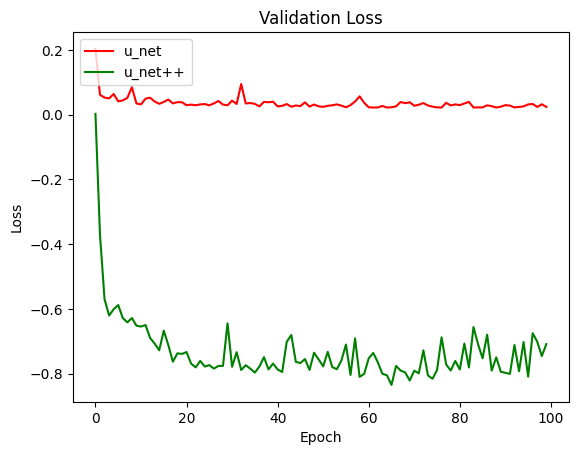

In [15]:
plt.plot(history.history['val_loss'], 'r')
plt.plot(plus_history.history['val_loss'], 'g')
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['u_net', 'u_net++'], loc='upper left')

plt.show()

---

### **(4) Ï†ïÏÑ±Ï†Å/Ï†ïÎüâÏ†Å ÌèâÍ∞Ä**

In [16]:
# # model Î∂àÎü¨Ïò§Í∏∞
# model_path = '/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER/seg_model_unet.h5'
# plus_model_path = '/Users/yena/Desktop/python_study/AIFFEL/GOINGDEEPER/seg_model_unet_plus_plus.h5'
 
# model = tf.keras.models.load_model(model_path)
# plus_model = tf.keras.models.load_model(plus_model_path)

In [27]:
# IoU Í≥ÑÏÇ∞ (Ï†ïÎüâÏ†Å ÌèâÍ∞Ä)
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    # print('IoU : %f' % iou_score )    # ÌèâÍ∑† Íµ¨Ìï† Îïå Ï£ºÏÑù Ï≤òÎ¶¨ÌïòÍ≥† ÏßÑÌñâÌï®
    return iou_score

In [18]:
# Ïù¥ÎØ∏ÏßÄ ÌôïÏù∏ (Ï†ïÏÑ±Ï†Å ÌèâÍ∞Ä)
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  # threshold : 0.5
    prediction = output/255   # ÎèÑÎ°úÎ°ú ÌåêÎã®Ìïú ÏòÅÏó≠
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5) # Ï†ïÏÑ±Ï†Å Í≤∞Í≥º
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # ÎùºÎ≤®ÏóêÏÑú ÎèÑÎ°úÎ°ú Í∏∞Ïû¨Îêú ÏòÅÏó≠

        return output, prediction, target
    else:
        return output, prediction, _

**[U-Net Model]**

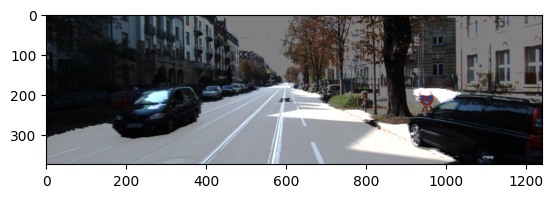

IoU : 0.894530


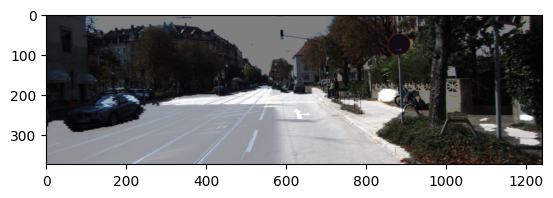

IoU : 0.851057


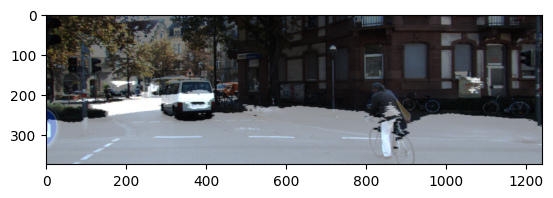

IoU : 0.626336


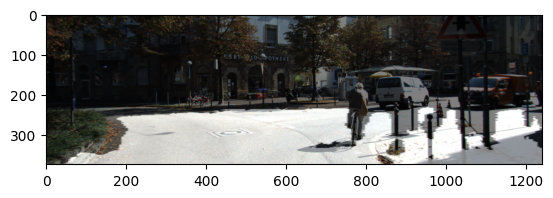

IoU : 0.607883


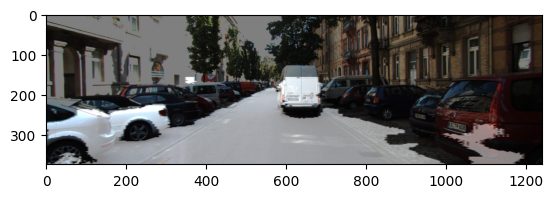

IoU : 0.482230


In [19]:
for i in range(5):
    output, prediction, target = get_output(
         model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
        )
    plt.imshow(output)
    plt.show()
    calculate_iou_score(target, prediction)

**[U-Net++ Model]**

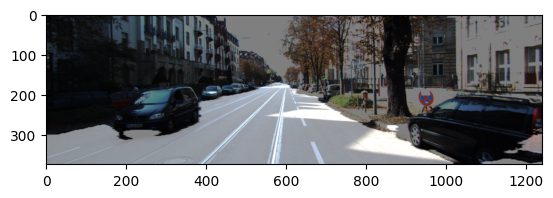

IoU : 0.912230


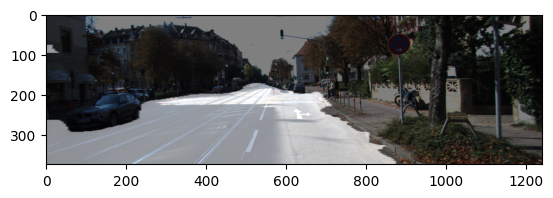

IoU : 0.930692


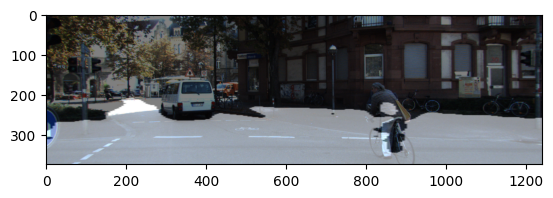

IoU : 0.642486


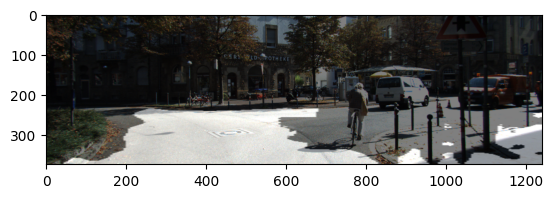

IoU : 0.540286


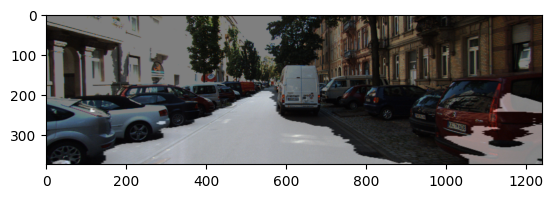

IoU : 0.575167


In [21]:
for i in range(5):
    output, prediction, target = get_output(
         plus_model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
        )
    plt.imshow(output)
    plt.show()
    calculate_iou_score(target, prediction)

In [29]:
# ÌèâÍ∑† Iou ÎπÑÍµê
unet_iou = []
unet_pp_iou = []

for i in range(200):
    output, prediction, target = get_output(
         model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
        )
    unet_iou.append(calculate_iou_score(target, prediction))
    
    pp_output, pp_prediction, pp_target = get_output(
         plus_model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
        )
    unet_pp_iou.append(calculate_iou_score(pp_target, pp_prediction))
    

unet = sum(unet_iou)/len(unet_iou)
unet_pp = sum(unet_pp_iou)/len(unet_pp_iou)

print('U-Net ÌèâÍ∑† IOU : ', round(unet, 4))
print('U-Net++ ÌèâÍ∑† IOU : ', round(unet_pp, 4))


U-Net ÌèâÍ∑† IOU :  0.7484
U-Net++ ÌèâÍ∑† IOU :  0.7025


---

### **[Í≥†Ï∞∞]**

<U>ÏòàÏÉÅ Í≤∞Í≥º</U>   
   
- U-Net++Ïùò ÏÑ±Îä•(ÌèâÍ∑† IoU)Ïù¥ ÎÜíÍ≤å ÎÇòÌÉÄÎÇ† Í≤ÉÏù¥Îã§. 
  
<U>Ïã§Ìóò Í≤∞Í≥º</U>  
  
- ÏòàÏÉÅÍ≥º Îã§Î•¥Í≤å U-NetÏùò ÌèâÍ∑† IoUÍ∞Ä .7484Î°ú U-Net++Ïùò ÌèâÍ∑† IoUÏù∏ .7025Î≥¥Îã§ ÎÜíÍ≤å ÎÇòÏôîÎã§.  
  
- ÏãúÍ∞ÅÌôîÌïú Ïù¥ÎØ∏ÏßÄÎ•º ÌôïÏù∏ÌïòÎ©¥ U-Net++Í∞Ä Ìõ®Ïî¨ Ï†ÅÏùÄ ÏòÅÏó≠ÏùÑ ÎèÑÎ°úÎ°ú Ïù∏ÏãùÌïú Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÎã§. 


<U>ü§î</U>  


![]()
<img src="https://imgur.com/jsx1iP8.png" width="500px" height="200px" title="px(ÌîΩÏÖÄ) ÌÅ¨Í∏∞ ÏÑ§Ï†ï" alt="Markdown Image"></img><br/> 


- Backbone ÏóÜÏù¥ Íµ¨Ï°∞Îßå Íµ¨ÌòÑÌñàÍ∏∞ ÎïåÎ¨∏Ïóê ÎÖºÎ¨∏Í≥º Îã§Î•∏ Í≤∞Í≥ºÍ∞Ä ÎÇòÏôîÏùÑ Ïàò ÏûàÎã§.
  
    - resnet101ÏùÑ backboneÏúºÎ°ú ÌïòÏó¨ ÎÖºÎ¨∏ Íµ¨ÌòÑÏùÑ ÏãúÎèÑÌñàÏúºÎÇò Ïã§Ìå®ÌïòÍ≥† Íµ¨Ï°∞Îßå Íµ¨ÌòÑÌñàÎã§.
    - conv0_0, conv1_0, conv2_0, conv3_0, conv4_0Î°ú Í∞ÄÏ†∏Ïò® layerÏôÄ Íµ¨ÌòÑÌïú layerÎ•º ÌôïÏù∏ÌïòÎäî Í≥ºÏ†ïÏù¥ ÌïÑÏöîÌïòÎã§.  
    - model.summary() Îøê ÏïÑÎãàÎùº keras.utils.plot_model(model, show_shapes=True)ÏùÑ ÌôúÏö©ÌïòÎäî Í≤ÉÏù¥ Ï¢ãÎã§.